# **Modeling Notebook**

### In this notebook we will pick up where we left off and start with our next model(s) for evaluation, keeping track of them through our metrics table up top.  Once we finish all of our models we will select the ones to continue with the model stack and then on to the Bayes Optimization.

#### First as usual let's read in our dataframe for usage and train our X,y values for our models to come.

In [13]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


In [2]:
df_scaled = pd.read_csv(f'/Users/ryanm/Desktop/df-scaled.csv')
print(df_scaled.shape)
df_scaled.head(5)

(3214874, 24)


,user_id,order_number,order_id,order_dow,order_hour_of_day,product_id,reordered,aisle_id,department_id,product_name_code,...,user_product_order_count,avg_cart_position,product_popularity,user_reorder_proportion,total_user_unique_products,total_orders,days_since_prior_order,add_to_cart_order,avg_days_between_orders,std_days_between_orders
0,1,1,2539329,3,9,26405,0,54,17,31683,...,-0.410997,-1.920683,-0.508987,0.146423,-0.76297,-0.901902,0.031628,-0.676228,1.461402,1.007456
1,1,2,2398795,4,8,26088,1,23,19,980,...,-0.551215,-1.689794,-0.513694,0.146423,-0.76297,-0.901902,0.493386,-0.543345,1.461402,1.007456
2,1,3,473747,4,13,30450,1,88,13,7124,...,-0.551215,-1.592202,-0.470523,0.146423,-0.76297,-0.901902,1.186023,-0.676228,1.461402,1.007456
3,1,4,2254736,5,8,26405,1,54,17,31683,...,-0.410997,-1.920683,-0.508987,0.146423,-0.76297,-0.901902,2.109539,-0.676228,1.461402,1.007456
4,1,5,431534,5,16,41787,1,24,4,2419,...,-0.551215,-0.666268,-0.352629,0.146423,-0.76297,-0.901902,1.994099,-0.277578,1.461402,1.007456


In [3]:
X = df_scaled.drop('reordered', axis = 1)
y = df_scaled['reordered']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Below you will see a table that summarizes all the metrics of each model we are building in this project.  We will use this to not only quickly visualize how each performed but to be able to pick which models we wish to see how the metrics that we use progress throughout the project.

In [4]:
models = ['Logistic Regression Base', 'LogReg SMOTE', 'XGBoost']
precision = [0.86, 0.90, 0.99]
recall = [0.88, 0.82, 0.99]
f1 = [0.82, 0.84, 0.99]
table_roc_auc_score = [0.77, 0.89, 1.00]

table_metrics = {
    'Model' : models,
    'Precision' : precision,
    'Recall' : recall,
    'F1 Score' : f1,
    'ROC AUC Score' : table_roc_auc_score
}

metrics_df = pd.DataFrame(table_metrics)
print(metrics_df)



                      Model  Precision  Recall  F1 Score  ROC AUC Score
0  Logistic Regression Base       0.77    0.88      0.82           0.59
1              LogReg SMOTE       0.90    0.82      0.84           0.89
2                   XGBoost       0.99    0.99      0.99           1.00


#### We will continue on now with a XGBoost model to prepare the predictions of our users' future top products.

In [5]:

xgb = XGBClassifier(
    use_label_encoder = False,
    eval_metric = 'logloss',
    objective = 'binary:logistic',
    learning_rate = 0.1,
    max_depth = 6,
    n_estimators = 100,
    subsample = 0.8,
    colsample_bytree = 0.8,
    gamma = 1,
    reg_alpha = 0.01,
    reg_lambda = 1
)

xgb.fit(X_train, y_train)
xgb_proba = xgb.predict_proba(X_test)[:,1]

print("XGBoost ROC AUC: ", roc_auc_score(y_test, xgb_proba))
print(classification_report(y_test, xgb.predict(X_test)))


XGBoost ROC AUC:  0.9996146452204154
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     77551
           1       0.99      1.00      1.00    565424

    accuracy                           0.99    642975
   macro avg       1.00      0.98      0.99    642975
weighted avg       0.99      0.99      0.99    642975



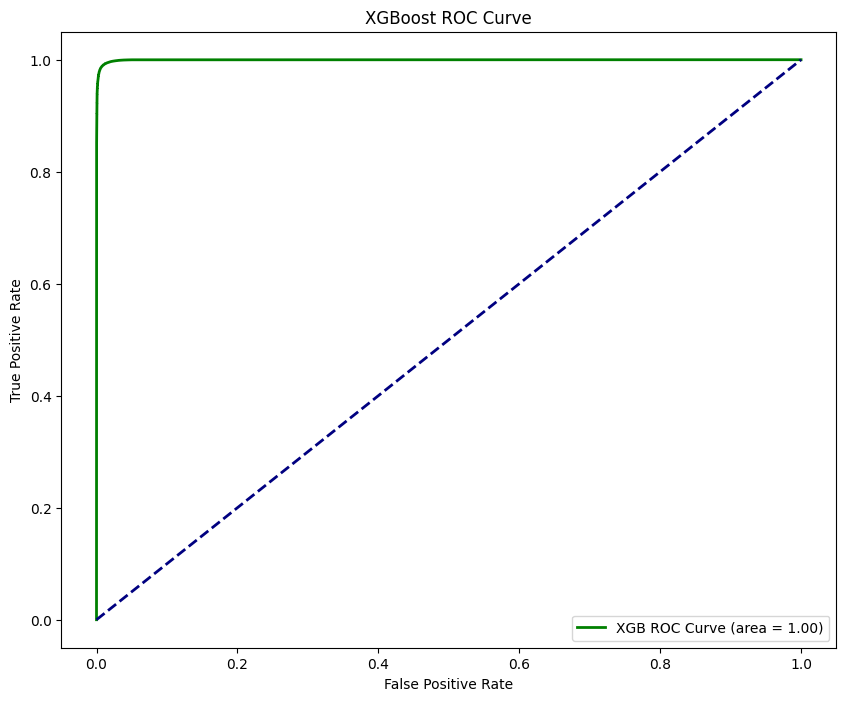

In [6]:
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_proba)
xgb_roc_auc = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize = (10,8))
plt.plot(fpr_xgb, tpr_xgb, color = 'green', lw = 2, label = 'XGB ROC Curve (area = %0.2f)' % xgb_roc_auc)
plt.plot([0,1], [0,1], color = 'navy', lw = 2, linestyle = '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curve")
plt.legend(loc = 'lower right')
plt.show()

#### What a 'boost' to the overall scores.  However before we celebrate let's do some checks and make sure that we aren't missing something and that the XGBoost model is indeed performing as advertised.  Let's conduct a cross-validation as well as a learning curve just to make sure we have full confidence in the metrics provided before we make a decision going forward.

In [7]:
cv_scores = cross_val_score(xgb, X_train, y_train, cv = 5, scoring = 'roc_auc')
print("Cross-Validation ROC AUC Scores: ", cv_scores)
print("Mean Cross-Validation ROC AUC: ", np.mean(cv_scores))





Cross-Validation ROC AUC Scores:  [0.99965472 0.9996401  0.9996346  0.99964585 0.99964471]
Mean Cross-Validation ROC AUC:  0.9996439954838763


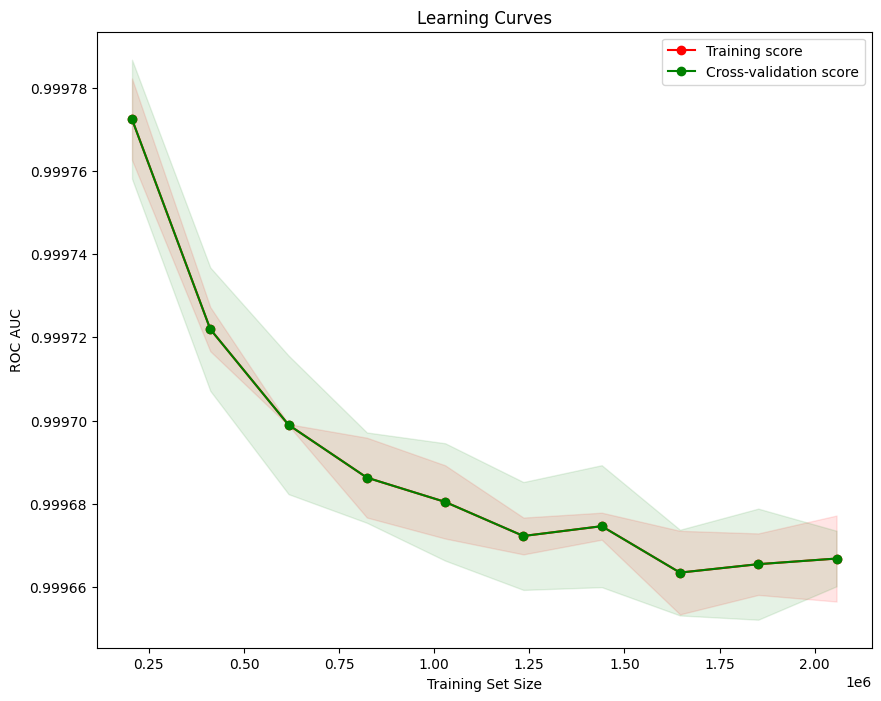

In [8]:
train_sizes, train_scores, val_scores = learning_curve(
    xgb, X_train, y_train, cv = 5, scoring = 'roc_auc', n_jobs = -1,
    train_sizes = np.linspace(0.1, 1, 10) 
)

train_scores_mean = np.mean(train_scores, axis = 1)
train_scores_std = np.std(train_scores, axis = 1)
val_scores_mean = np.mean(train_scores, axis = 1)
val_scores_std = np.std(val_scores, axis = 1)

plt.figure(figsize = (10,8))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = 0.1, color = 'r')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha = 0.1, color = 'g')
plt.plot(train_sizes, train_scores_mean, 'o-', color = 'r', label = 'Training score')
plt.plot(train_sizes, val_scores_mean, 'o-', color = 'g', label = 'Cross-validation score')
plt.xlabel("Training Set Size")
plt.ylabel("ROC AUC")
plt.title("Learning Curves")
plt.legend(loc = 'best')
plt.show()




#### So while it is great that our cross-validation confirmed our initial scores the learning curve plot is showing signs that there is still issues with our data (due to the downward sloping line).  We know from our results when running our SMOTE Logistic Regression model that it helped with imbalancing in our target variable.  Let's stack our two models and see if it helps our learning curve.  Let's start by running our previous Preprocessing notebook here so we can utilize the variables contained there as well as the work done so we don't have to recreate.

['GridSearchCV', 'In', 'LogisticRegression', 'Out', 'SMOTE', 'StandardScaler', 'X', 'XGBClassifier', 'X_test', 'X_train', 'X_train_smote', '_', '_2', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '__vsc_ipynb_file__', '_dh', '_i', '_i1', '_i10', '_i11', '_i2', '_i3', '_i4', '_i5', '_i6', '_i7', '_i8', '_i9', '_ih', '_ii', '_iii', '_oh', 'accuracy_score', 'auc', 'best_model_smote', 'best_params_smote', 'best_score_smote', 'classification_report', 'confusion_matrix', 'cross_val_score', 'cv_scores', 'df_mod', 'df_num_scaled', 'df_numerical', 'df_scaled', 'existing_num_features', 'exit', 'f1', 'fpr', 'fpr_smote', 'fpr_xgb', 'get_ipython', 'grid_search_smote', 'learning_curve', 'lr', 'lr_acc', 'lr_cls_report', 'lr_conf_matrix', 'lr_roc_auc', 'lr_roc_auc_smote', 'lr_y_pred', 'main_path', 'metrics_df', 'models', 'np', 'num_features', 'open', 'os', 'param_grid', 'pd', 'plt', 'precision', 'precision_score', 'probs', 'quit', 'recall',

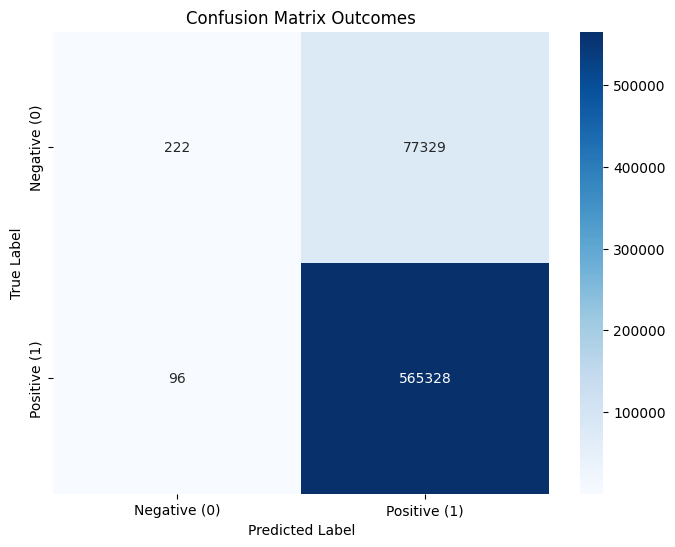

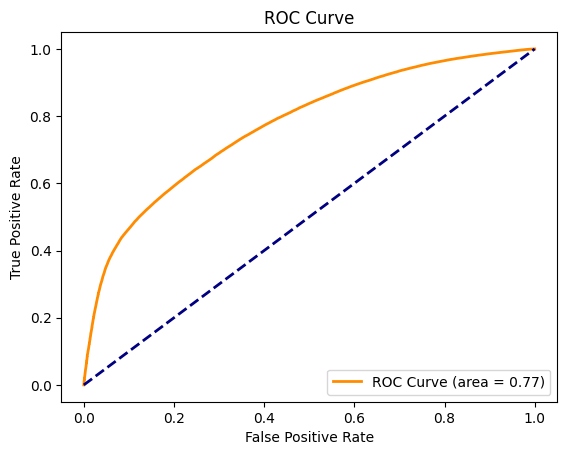

SMOTE Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
SMOTE Best Score: 0.9160819113384129
SMOTE Test ROC AUC Score: 0.8897391058846963
              precision    recall  f1-score   support

           0       0.38      0.83      0.52     77551
           1       0.97      0.82      0.89    565424

    accuracy                           0.82    642975
   macro avg       0.68      0.82      0.70    642975
weighted avg       0.90      0.82      0.84    642975



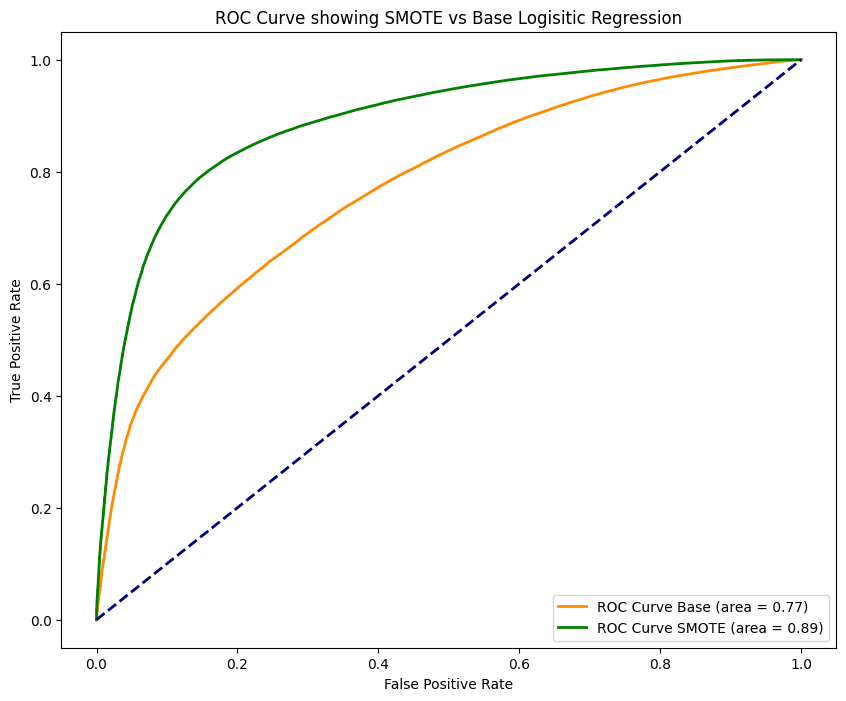

['GridSearchCV', 'In', 'LogisticRegression', 'Out', 'SMOTE', 'StandardScaler', 'X', 'XGBClassifier', 'X_test', 'X_train', 'X_train_smote', '_', '_2', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '__vsc_ipynb_file__', '_dh', '_i', '_i1', '_i10', '_i11', '_i2', '_i3', '_i4', '_i5', '_i6', '_i7', '_i8', '_i9', '_ih', '_ii', '_iii', '_oh', 'accuracy_score', 'auc', 'best_model_smote', 'best_params_smote', 'best_score_smote', 'classification_report', 'confusion_matrix', 'cross_val_score', 'cv_scores', 'df_mod', 'df_num_scaled', 'df_numerical', 'df_scaled', 'existing_num_features', 'exit', 'f1', 'fpr', 'fpr_smote', 'fpr_xgb', 'get_ipython', 'grid_search_smote', 'learning_curve', 'lr', 'lr_acc', 'lr_cls_report', 'lr_conf_matrix', 'lr_roc_auc', 'lr_roc_auc_smote', 'lr_y_pred', 'main_path', 'metrics_df', 'models', 'np', 'num_features', 'open', 'os', 'param_grid', 'pd', 'plt', 'precision', 'precision_score', 'probs', 'quit', 'recall',

In [11]:
print(dir())
%run preprocessing.ipynb
print(dir())

#### Great, now let's continue on with our model stack, combining the efforts of our previous SMOTE Logistic Regression model and our XGBoost model together to get one singular output.

In [12]:
meta_feats = np.column_stack((y_pred_proba_smote, xgb_proba))
meta_target = y_test


In [ ]:
base_models = [('log_reg_smote', best_model_smote), ('xgb', xgb)]
param_grid_meta = {
    'final_estimator__penalty' : ['l2'],
    'final_estimator__C' : [0.1, 1, 10],
    'solver' : ['liblinear']
}

In [ ]:
stacking_clf = StackingClassifier(estimators = base_models, final_estimator=LogisticRegression(random_state=42, max_iter=1000))

stack_grid_search = GridSearchCV(
    estimator = stacking_clf,
    param_grid = param_grid_meta,
    cv=3,
    scoring = 'roc_auc',
    n_jobs = -1
)

stack_grid_search.fit(X_train, y_train)

In [ ]:

best_stacked_model = stack_grid_search.best_model_
best_stacked_params = stack_grid_search.best_params_
best_stacked_score = stack_grid_search.best_score_








In [10]:
main_path = r'C:/Users/ryanm/Desktop/df-scaled.csv'

#df_mod = df
df_scaled.to_csv(main_path, index = False)